# Прогнозирование объема расчетных счетов клиентов для Сбербанка

**Описание проекта**

В файле data.csv (находится в архиве "Вспомогательный данные") представлены подневные данные объема расчетных счетов физических лиц. В отличие от депозита, клиент может снять всю сумму с расчетного счета в любой момент времени без каких-либо «штрафов». Такой продукт называют Undefined Maturity Product – UMP). Однако маловероятно, что все клиенты разом закроют свои счета в Банке. Всегда кто-то снимает деньги, а кто-то пополняет счет – есть некоторый стабильный уровень, ниже которого не опустится суммарный обьем расчетных счетов.

**Задача:**

Определить объем стабильных средств по расчетным счетам физических лиц, то есть понять, какой объем из всей суммы счетов является стабильным на горизонте 1М, 2М, 3М и тд.

Нужно одновременно минимизировать величины:

* максимальный объем пробития стабильный части на валидационной выборке
* фактическая стабильная часть – модельная стабильная часть

**План проекта**

1. Обзор данных, подготовка и ресемплирование
2. Анализ скользящего среднего, трендов и сезонности
3. Подготовка данных: создание признаков, разделение на выборки
4. Обучение моделей и оценка их качества
5. Тестирование лучшей модели
6. Визуализация результатов

# 1. Обзор данных

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from fast_ml.model_development import train_valid_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
!pip install xgboost
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [3]:
data = pd.read_csv('data.csv', sep=';', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)
data.info()
data.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2111 entries, 2013-12-30 to 2019-12-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   VALUE   2111 non-null   int64
dtypes: int64(1)
memory usage: 33.0 KB


,VALUE
REPORTDATE,
2013-12-30,3457625638
2013-12-31,3417092149
2014-01-01,3417092149
2014-01-02,4333581643
2014-01-03,5010720003


В файле data.csv представлены подневные данные объема расчетных счетов физических лиц. 

Для временного ряда необходимо построить модель, которая оценивает обьем стабильной части средств на дату. 

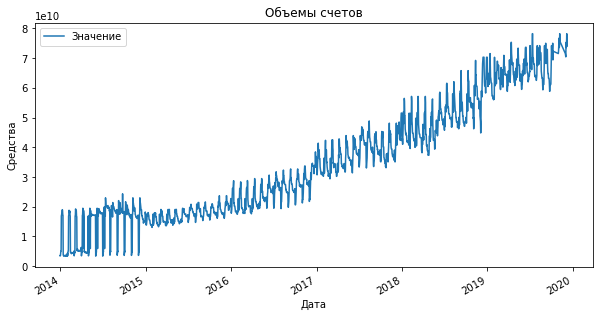

In [4]:
data.plot(figsize=(10,5))

plt.title('Объемы счетов')
plt.xlabel('Дата')
plt.ylabel('Средства')
plt.legend(['Значение'])
plt.show()

В нашем распоряжении подневные данные с 2014 до 2020 года. Чтобы проанализировать тренды и сезонности в данных, проведем ресемплирование по месяцу, так как нам необходимо предсказать объем стабильных средств на следующие несколько месяцев.

### Ресемплирование

In [5]:
resample = data.resample('1M').mean()

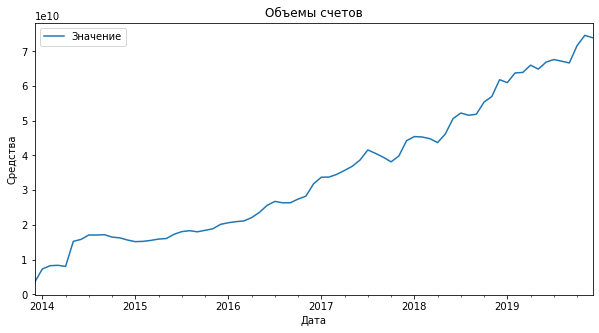

In [6]:
resample.plot(figsize=(10, 5))

plt.title('Объемы счетов')
plt.xlabel('Дата')
plt.ylabel('Средства')
plt.legend(['Значение'])
plt.show()

# 2. Анализ данных

### Скользящее среднее

Проанализируем изменения объема счетов в течении 5 лет и 1 года.

In [7]:
df2 = data['2015-01-01':'2019-12-9']
df2['rolling_mean'] = data.rolling(30).mean()

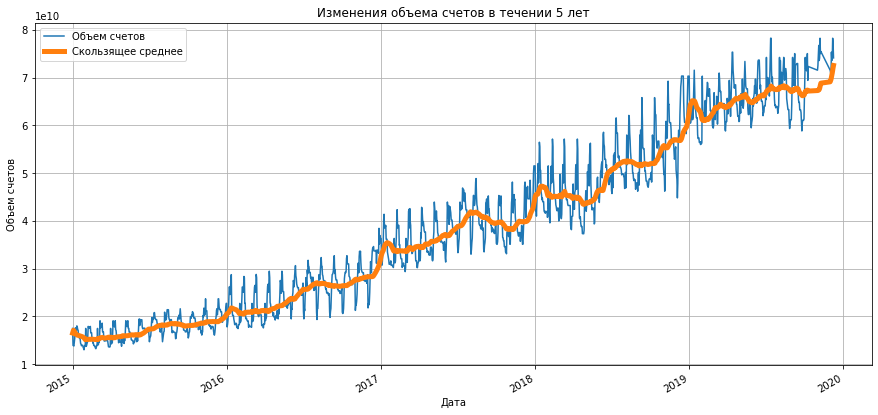

In [8]:
df2['VALUE'].plot(figsize=(15, 7), grid=True)
df2['rolling_mean'].plot(figsize=(15, 7), grid=True, linewidth=5)

plt.title('Изменения объема счетов в течении 5 лет')
plt.xlabel('Дата')
plt.ylabel('Объем счетов')
plt.legend(['Объем счетов', 'Скользящее среднее'])
plt.show()

На графике мы можем проследить следующее:
- Имеется стабильный рост объема счетов с каждым годом в среднем на 10 млрд.
- До 2017 года рост был более равномерный, без колебаний, чем после 2017 года

In [9]:
df3 = data['2018-10-01':'2019-09-30']
df3['rolling_mean'] = data.rolling(30).mean()

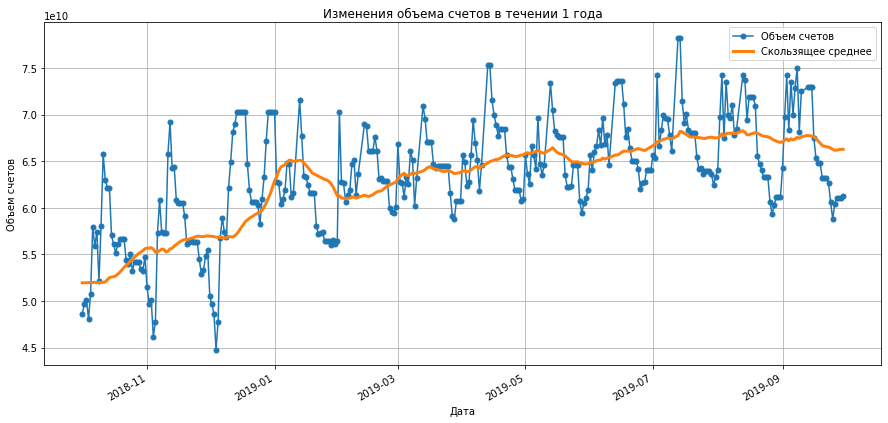

In [10]:
df3['VALUE'].plot(figsize=(15, 7), grid=True, marker='o', markersize = 5)
df3['rolling_mean'].plot(figsize=(15, 7), grid=True, linewidth=3)

plt.title('Изменения объема счетов в течении 1 года')
plt.xlabel('Дата')
plt.ylabel('Объем счетов')
plt.legend(['Объем счетов', 'Скользящее среднее'])
plt.show()

На графике видно следующее:
- Стабильное колебание размера счетов каждый месяц
- В начале года прослеживается более сильное снижение объема расчетных счетов, чем в середине

### Тренды и сезонность

Исследуем тренд за все время, которое у нас есть, а также сезонную компоненту: для этого визуализируем её за период 5 лет и 1 год.

In [11]:
df4 = data['2014-01-01' : '2019-12-09'].resample('1M').mean()

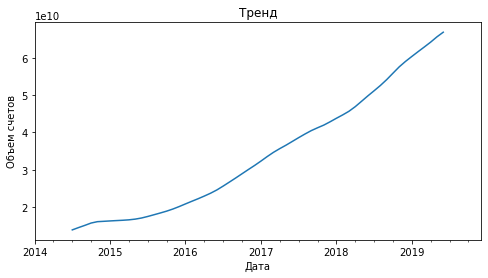

In [12]:
decomposed = seasonal_decompose(df4)

plt.figure(figsize=(8, 4))
decomposed.trend.plot(ax=plt.gca())


plt.title('Тренд')
plt.xlabel('Дата')
plt.ylabel('Объем счетов')
plt.show()

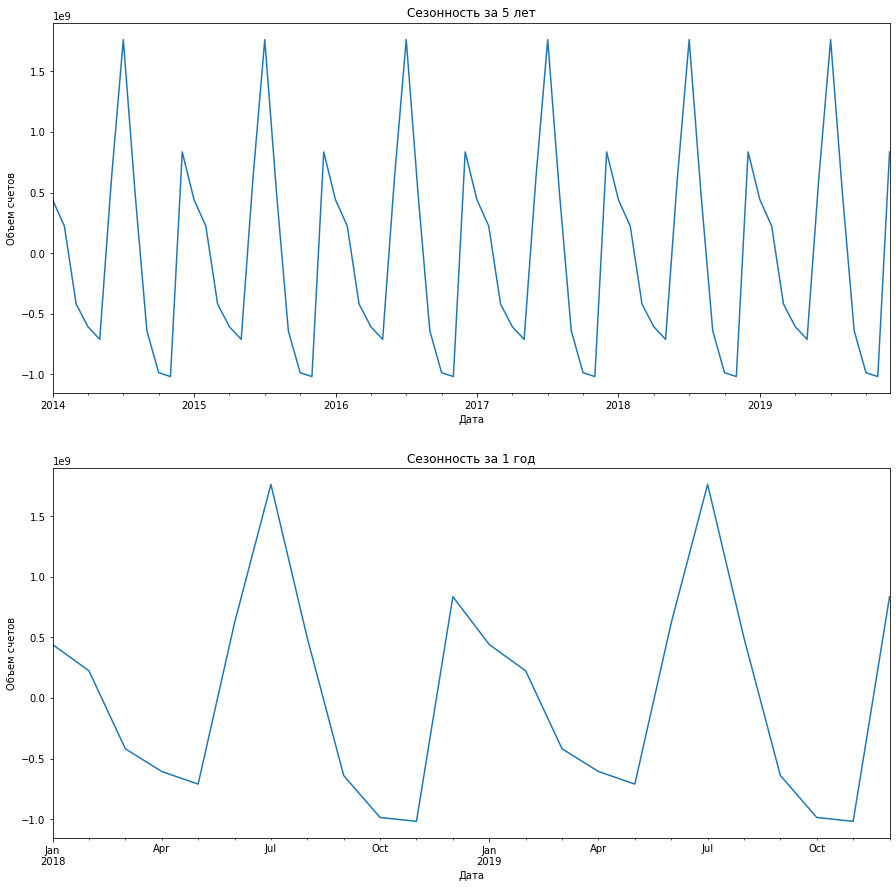

In [13]:
plt.figure(figsize=(15, 15))

plt.subplot(2, 1, 1)
decomposed.seasonal['2014-01-31' : '2019-12-31'].plot(ax=plt.gca())
plt.title('Сезонность за 5 лет')
plt.xlabel('Дата')
plt.ylabel('Объем счетов')

plt.subplot(2, 1, 2)
decomposed.seasonal['2018-01-31' : '2019-12-31'].plot(ax=plt.gca())
plt.title('Сезонность за 1 год')
plt.xlabel('Дата')
plt.ylabel('Объем счетов')


plt.show()

На графике мы можем видеть ежегодную сезонность: к началу лета средств на счетах клиентов больше всего, что можно объяснить сбережением средств на поездку летом. К концу октября средства заканчиваются и клиенты снова копят на отдых в праздники, затем постепенно к середине весны объем счетов снова уменьшается.

# 3. Подготовка данных

### Создание признаков

In [14]:
# после сентября 2019 года у нас имеются неполные данные, удалим их
df = data['2013-12-30' : '2019-09-30']

In [15]:
# напишем функцию, которая создает признаки для выборки
def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['VALUE'].shift(lag)

    data['rolling_mean'] = data['VALUE'].rolling(rolling_mean_size).mean()
    data['rolling_mean'] = data['rolling_mean'].shift()
    
    return data


In [16]:
# применим функцию и удалим пропуски
data = make_features(df, 25, 10)
data = data.dropna()

warnings.filterwarnings('ignore')

In [17]:
# подберем лучшие параметры для признаков

train, test = train_test_split(data, shuffle=False, test_size=0.2)

features_train = train.drop('VALUE', axis=1)
target_train = train['VALUE']
features_test = test.drop('VALUE', axis=1)
target_test = test['VALUE']

In [18]:
model = LinearRegression()

model.fit(features_train, target_train)
prediction = model.predict(features_test)

print("MAE тестовой выборки:", mean_absolute_error(target_test, prediction))

MAE тестовой выборки: 2051650684.511112


Мы добавили необходимые признаки для обучения модели и подобрали подходящие параметры для них

### Разделение на выборки

In [19]:
# выделим целевой признак
features = data.drop('VALUE', axis=1)
target = data['VALUE']

In [20]:
# отделим тренировочную и тестовую выборки для кросс-валидации
features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                           shuffle=False, test_size=0.2)

In [21]:
# проверим размер и упорядоченность выборок
print (f'Тестовая выборка составляет {features_test.shape[0]/features.shape[0]:.0%} от исходного датасета')

if (features_train.index.max() < features_test.index.min()):
    print ('Последовательность в выборках сохранена')
else:
    print ('Последовательность в выборках нарушена')

Тестовая выборка составляет 20% от исходного датасета
Последовательность в выборках сохранена


# 4. Обучение моделей

**ElasticNet**

Обучим модель и проведем кросс-валидацию с помощью GridSearch

In [22]:
# создадим общий кросс-валидатор
tscv = TimeSeriesSplit(n_splits=5)

In [23]:
# зададим параметры для модели
parameters_en = {'l1_ratio': np.arange(0.1, 1.1, 0.1), 'max_iter' : range(100, 501, 100)}

# переберем гиперпараметры и проведем кросс-валидацию
grid_en = GridSearchCV(ElasticNetCV(random_state=42), param_grid = parameters_en,  
                       scoring = 'neg_root_mean_squared_error', n_jobs=-1, cv=tscv)


In [24]:
%%time

# обучим модель и сохраним результаты
grid_en.fit(features_train, target_train)

best_en_model = grid_en.best_estimator_
best_en_score = abs(grid_en.best_score_)

print ('Лучший результат ElasticNet: ', best_en_score)
print ('Лучшая модель ElasticNet: ', best_en_model)

Лучший результат ElasticNet:  1965031981.8560383
Лучшая модель ElasticNet:  ElasticNetCV(l1_ratio=0.1, max_iter=200, random_state=42)
Wall time: 20.4 s


Средняя квадратичная ошибка модели ~ 2 млрд, проверим другие модели.

**Линейная регрессия**

In [25]:
# оценим эффективность линейной регрессии кросс-валидацией
best_linear_model = 0
best_linear_score = 1000

for depth in range(1, 10):
    
    model = LinearRegression()
    scores = cross_val_score(model, features_train, target_train, cv=tscv, scoring = 'neg_root_mean_squared_error')
    score = pd.Series(scores).mean()
    
    if score < best_linear_score:
        best_linear_score = score
        best_linear_model = model

print ('Лучший результат Линейной регрессии: ', abs(best_linear_score))

Лучший результат Линейной регрессии:  2279191281.732339


Средняя квадратичная ошибка модели линейной регрессии ~ 2,3 млрд, проверим другие модели.

**XGB**

In [26]:
# зададим параметры для модели
parameters_xgb = {'max_depth' : [6], 'n_estimators' :  [41],
                 'learning_rate' : np.arange(0.1, 0.6, 0.1), 'reg_alpha': np.arange(0.1, 0.4, 0.1)}

# переберем гиперпараметры и проведем кросс-валидацию
grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid = parameters_xgb,  
                       scoring = 'neg_root_mean_squared_error', n_jobs=-1, cv=tscv)


In [27]:
%%time

# обучим модель и сохраним результаты
grid_xgb.fit(features_train, target_train)

best_xgb_model = grid_xgb.best_estimator_
best_xgb_score = abs(grid_xgb.best_score_)

print ('Лучший результат XGBRegressor: ', best_xgb_score)

Лучший результат XGBRegressor:  5158092123.735994
Wall time: 16.7 s


Для прогнозирования объема средств на счетах у клиентов лучше всего подходит модель ElasticNet. Протестируем модель, затем, сделаем предсказания и визуализируем их.

# Тестирование модели

Проверим модель на тестовой выборке

In [28]:
best_en_model.fit(features_train, target_train)
prediction_en = best_en_model.predict(features_test)
score = mean_squared_error(target_test, prediction_en) ** 0.5

print ('Лучший результат ElasticNet: ', score)

best_linear_model.fit(features_train, target_train)
prediction_linear = best_linear_model.predict(features_test)
score2 = mean_squared_error(target_test, prediction_linear) ** 0.5

print ('Лучший результат линейной регрессии: ', score2)

Лучший результат ElasticNet:  2836532669.9191847
Лучший результат линейной регрессии:  2902495615.001278


Проверим модель на адекватность - сравним с константной моделью `DummyRegressor`

In [29]:
model = DummyRegressor(strategy = 'mean')
model.fit(features_train, target_train)
predictions = model.predict(features_test)
score3 = mean_squared_error(target_test, predictions) ** 0.5

print ('RMSE константной модели: ', score3)

RMSE константной модели:  35577355651.94604


Модель прогнозирует объем счетов намного лучше константной модели, можем визуализировать результаты.

# Визуализация

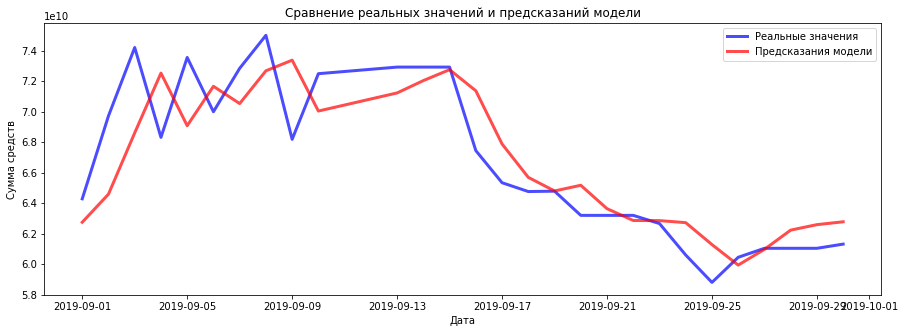

In [30]:
# предсказания объема счетов клиентов банка находятся в переменной prediction_en
predictions = pd.DataFrame(prediction_en, index=target_test.index, columns=['value'])

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(target_test['2019-09-01':'2019-09-30'], linewidth=3, alpha=0.7, color='b')
ax.plot(predictions['2019-09-01':'2019-09-30'], linewidth=3, color='r', alpha=0.7)

plt.title('Сравнение реальных значений и предсказаний модели')
plt.xlabel('Дата')
plt.ylabel('Сумма средств')
plt.legend(['Реальные значения', 'Предсказания модели'])
plt.show()

In [31]:
# напишем функцию, которая принимает на вход количество месяцев и
# возвращает максимальный объем пробития стабильной части за этот перод

def maxmin(prediction, months):

    first_months = prediction.head(months * 30)
    
    return first_months['value'].min(), first_months['value'].max()

In [32]:
# выведем результат и сохраним его в список

minimum = []
maximum = []

for i in range(1, 7):
    
    mm = maxmin(predictions, i)
    
    minimum.append(mm[0])
    maximum.append(mm[1])
    
    print (f'Минимальный объем средств на счетах клиентов на горизонте {i} месяцев:', int(mm[0]) )
    print (f'Максимальный объем средств на счетах клиентов на горизонте {i} месяцев:', int(mm[1]) )
    print (' ')

Минимальный объем средств на счетах клиентов на горизонте 1 месяцев: 48350084230
Максимальный объем средств на счетах клиентов на горизонте 1 месяцев: 60418678868
 
Минимальный объем средств на счетах клиентов на горизонте 2 месяцев: 47501513564
Максимальный объем средств на счетах клиентов на горизонте 2 месяцев: 61591062639
 
Минимальный объем средств на счетах клиентов на горизонте 3 месяцев: 47492651061
Максимальный объем средств на счетах клиентов на горизонте 3 месяцев: 62039682282
 
Минимальный объем средств на счетах клиентов на горизонте 4 месяцев: 47492651061
Максимальный объем средств на счетах клиентов на горизонте 4 месяцев: 66481068174
 
Минимальный объем средств на счетах клиентов на горизонте 5 месяцев: 47492651061
Максимальный объем средств на счетах клиентов на горизонте 5 месяцев: 68049590257
 
Минимальный объем средств на счетах клиентов на горизонте 6 месяцев: 47492651061
Максимальный объем средств на счетах клиентов на горизонте 6 месяцев: 69337714567
 


In [75]:
# сохраним результаты
index = pd.DataFrame({'year': [2018, 2018, 2018],
                   'month': [8, 8, 9],
                   'day': [2, 28, 26]})
ind = pd.to_datetime(index)
mi = pd.DataFrame(minimum[:3], index=ind)

index = pd.DataFrame({'year': [2018, 2018, 2018, 2018, 2018, 2019],
                   'month': [8, 9, 10, 11, 12, 1],
                   'day': [13, 12, 12, 13, 18, 14]})
ind = pd.to_datetime(index)
ma = pd.DataFrame(maximum, index=ind)

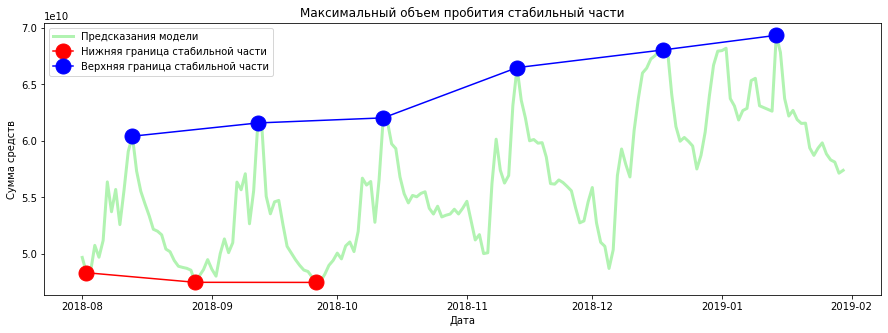

In [76]:
# визуализируем нижнюю и верхнюю границы стабильной части
predictions = pd.DataFrame(prediction_en, index=target_test.index, columns=['value'])

fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(predictions['2018-08-01':'2019-01-30'], linewidth=3, color='lightgreen', alpha=0.7)
ax.plot(mi, color='r', marker='o', markersize=15)
ax.plot(ma, color='b', marker='o', markersize=15)

plt.title('Максимальный объем пробития стабильный части')
plt.xlabel('Дата')
plt.ylabel('Сумма средств')
plt.legend(['Предсказания модели', 'Нижняя граница стабильной части', 'Верхняя граница стабильной части'])
plt.show()

**Вывод**

Задача проекта - определить объем стабильных средств по расчетным счетам физических лиц - выполнена.

Мы создали и обучили модель, которая предсказывает по историческим данным объем средств по расчетным счетам физических лиц, минимизировали величину RMSE. 

**С помощью данной модели мы можем предсказать минимальный и максимальный объем средств на счетах клиентов**

